In [3]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)   
    news = requests.get(url)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [4]:
url_list = make_urllist(2, 101, 20200506)
print('뉴스 기사의 개수: ',len(url_list))

뉴스 기사의 개수:  40


In [5]:
url_list[:5]

['https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451723',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451721',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451718',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=003&aid=0009849190',
 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001451717']

In [6]:
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [7]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

In [8]:
data = make_data(url_list, 101)
#- 상위 10개만 출력해봅니다.
data[:10]

,news,code
0,고려은단이 5월을 맞아 응원 메시지를 공유하는 ‘5월 5글자로 응원 부탁해!’ 이벤...,경제
1,코리아나화장품의 민감성 피부를 위한 저자극 스킨케어 브랜드 '프리엔제'가 마르고 건...,경제
2,서울장수주식회사가 부드럽고 달콤한 맛으로 인기를 모으고 있는 생막걸리 ‘인생막걸리’...,경제
3,[서울=뉴시스] 오동현 기자 = 모바일 게임 기업 컴투스는 3D 모바일 야구 게임 ...,경제
4,대원제약이 2020년 상반기 신입과 경력 정기 공채를 실시합니다.정기 공채 모집분야...,경제
5,"[AFP=연합뉴스] [AFP=연합뉴스]\n\n""요즘은 잔인한 날""…리프트도 앞서 9...",경제
6,이재용 삼성전자 부회장이 6일 삼성전자 서울 서초사옥에서 대국민 사과 회견을 하기 ...,경제
7,JW중외제약이 A형 혈우병 예방요법제 ‘헴리브라피하주사를 출시하고 본격적인 마케팅 ...,경제
8,"옵티팜과 휴벳바이오가 공동 개발중인 백신 후보 물질에 대해 마우스, 기니피그, 미니...",경제
9,[한국경제TV 신동호 기자]\n\n전남 나주시와 충북 청주시가 방사광 가속기 구축사...,경제


In [9]:
code_list = [102, 103, 105]

code_list

[102, 103, 105]

In [103]:
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [102]:
df = make_total_data(15, code_list, 20200706)

102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [104]:
df.to_csv('test.csv', header=False)

In [114]:
df = pd.read_csv('test.csv', encoding='utf-8')

In [115]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  899


In [116]:
df.sample(10)

,0,"안산시 보급 청소년용 안전주머니. 사진제공=안산시 안산시 보급 청소년용 안전주머니. 사진제공=안산시\n\n[안산=파이낸셜뉴스 강근주 기자] 안산시가 청소년 안전을 위해 마스크와 손세정제, 생명수건 등이 담긴 ‘안전주머니’를 관내 초-중학교에 5만여개를 보급한다.6일 안산시에 따르면 이달 내로 관내 초등학교 55개교와 중학교 29개교 등 모두 84개교의 학생 5만여명에게 안전주머니를 1개씩 전달할 예정이다.안전주머니에는 생명수건, KF94 마스크, 안전호루라기, 손세정제(30㎖) 등 4종류의 예방용품이 담겨져 있으며, 화재 및 범죄 등 긴급 상황에 신속히 대처할 수 있도록 가방에 걸 수 있게 제작됐다.생명수건은 자연 추출성 특수용액에 젖은 3중 필터형태의 습식 손수건으로 화재발생 시 코와 입을 막고 대피할 때 유독가스로부터 호흡을 원활히 할 수 있게 도와준다.마스크와 손세정제는 평소 코로나19 등 감염병 예방을 위해 활용할 수 있으며, 위험이 있거나 위기상황이 발생해 긴급히 주변에 도움을 요청해야 하는 경우에는 안전호루라기를 꺼내 사용하면 된다.안산시는 화재, 감염병 등 발생 시 일반 성인보다 재난상황을 피하기 어려운 18세 미만 어린이, 노인, 장애인 등 안전취약계층 안전과 피해를 최소화하기 위해 안전주머니를 제작-보급하고 있다.윤화섭 안산시장은 “화재 등 각종 재난과 위기상황에서 어린 학생을 안전하게 보호하기 위해 안전물품을 지원하게 됐다”며 “‘살맛나는 생생도시 안산’을 구현하고 시민 안전의식을 높이기 위해 안전물품 지원뿐만 아니라 안전 교육과 홍보도 지속 추진해 나가겠다”고 말했다.※ 저작권자 ⓒ 파이낸셜뉴스. 무단 전재-재배포 금지",사회
137,138,기사 섹션 분류 안내\n\n기사의 섹션 정보는 해당 언론사의 분류를 따르고 있습니다...,사회
715,116,트위터 엔지니어팀이 중립적인 단어로 교체예정인 개발용어 목록을 발표했다(표=트위터 ...,IT/과학
191,192,성남시의료원 전경[성남시 제공. 재판매 및 DB 금지] 성남시의료원 전경[성남시 제...,사회
389,90,윌슨 응 [사진= 서울시립교향악단 제공] 윌슨 응 [사진= 서울시립교향악단 제공]\...,생활/문화
392,93,[로마=AP/뉴시스]영화음악의 거장 엔니오 모리코네가 6일(현지시간) 이탈리아 로마...,생활/문화
619,20,PICK 안내 해당 언론사가 주요기사로\n\n직접 선정한 기사입니다. 언론사 편집판...,IT/과학
685,86,[디지털데일리 채수웅기자] 세종텔레콤(대표이사 김형진 유기윤)은 한국철도시설공단이 ...,IT/과학
359,60,"현재 충청과 남부 지방에 비구름이 관측되고 있는데요.특히, 충북 영동과 전북 무주에...",생활/문화
444,145,국립현대무용단이 오는 10~12일 서울 예술의전당 자유소극장에서 열릴 예정인 안무 ...,생활/문화
431,132,PICK 안내 해당 언론사가 주요기사로\n\n직접 선정한 기사입니다. 언론사 편집판...,생활/문화


In [119]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,Unnamed: 0,news,code
0,0,파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...,사회
1,1,동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...,사회
2,2,황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...,사회
3,3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회


In [120]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

0      파주시청 사진제공파주시 파주시청 사진제공파주시파주파이낸셜뉴스 강근주 기자 파주시는 ...
1      동영상 뉴스이천 물류창고 화재 발화지점으로 지목된 지하 층에서 산소절단기의 산소 공...
2      황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검 사진제...
3      귀갓길 여성을 쫓아가 성범죄를 시도한 대 남성이 구속됐습니다서울 강남경찰서는 강간상...
4      서울연합뉴스 대한약사회가 일부터 코로나바이러스 감염증 대응 체계를 사회적 거리두기에...
                             ...                        
595    지디넷코리아이도원 기자스마일게이트알피지대표 지원길는 블록버스터 핵앤슬래시 다중접속역...
596    모두의셔틀 로고 모두의셔틀 제공  뉴스 모두의셔틀 로고 모두의셔틀 제공  뉴스서울뉴...
597    휴온스의 신종 코로나바이러스 감염증코로나 관련 방역용품이 미국 수출길에 오른다휴온스...
598    코로나 치료제백신 개발 범정부 지원단은 오늘일부터 이틀 동안 관련 기업들을 대상으로...
599      전자신문  전자신문인터넷 무단전재 및 재배포 금지이재용 삼성전자 부회장이 세 경...
Name: news, Length: 600, dtype: object

In [121]:
print(df.isnull().sum())

Unnamed: 0    0
news          0
code          0
dtype: int64


In [122]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  552


In [123]:
# 중복 샘플 제거
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  552


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home

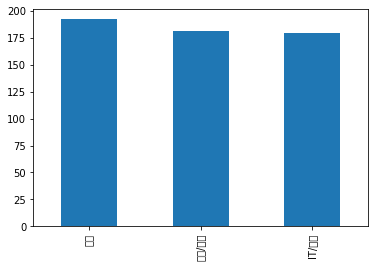

In [124]:
df['code'].value_counts().plot(kind = 'bar')

In [125]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    179
1     사회    192
2  생활/문화    181


In [71]:
from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


In [84]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스', '로', '게']

In [85]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [86]:
text_data = preprocessing(df['news'])
print(text_data[0])

파주 시청 사진제 공파 주시 파주 시청 사진 제공 파주시 파주 강근주 파 주 시 일 관내 취약 계층 만 가구 대해 정부 긴급 재난 지원금 입금 완료 다파 주 시민 받 긴급 재난 지원금 인 이상 가구 기준 으로 만 원 받 되 며 인 가구 만 원 인 가구 만 원 인 가구 만 원 정부 발표 긴급 재난 지원금 파주 시민 지급 금액 다른 이유 국비 지방비 부담 비율 다파 주 시 이미 모든 시민 경기도 파주시 재난 기본 소득 인 당 각 만 원 지급 고 어 시민 국비 지원금 만 지급 며 인 가구 기준 으로 총 지원 금액 파주시 재난 기본소득 만 원 경기도 재난 기본소득 만 원 정부 긴급 재난 지원금 만 원 총 만 원 받 된다 취약 계층 아닌 시민 오 월일 부터 소지 고 신용 체크카드 사 홈페이지 에서 긴급 재난 지원금 지원 신청 세대주 가족 지원금 일괄 신청 해야 한다 한편 파 주 시 일 김정기 부시장 단장 으로 긴급 재난 지원금 추진 태 스 크 포스 를 구성 해 긴급 재난 지원금 원활 지급 될 도록 지원 한다 권 자 재 배포


데이터에 대한 전처리가 끝났다면 드디어 머신 러닝 모델을 적용해 볼 때가 되었습니다! 이번 실습에서 사용할 머신 러닝 모델은 '나이브 베이즈 분류기'라는 모델입니다. 나이브 베이즈 분류기를 이해하기 위해서 아래의 영상을 시청해 보겠습니다.

> 모든 메일에는 같은 단어가 중복으로 등장하지 않는다고 가정하였을 때, 베이즈의 정리만을 이용하여 coupon이라는 단어가 들어갔을 때 해당 메일이 스팸 메일일 확률을 구해 보세요. 가정은 아래와 같습니다!    
   
   
- 총 8개의 메일 중에 4개의 메일이 스팸 메일입니다.
   
   
- 전체 메일 중에서 coupon이라는 단어가 들어간 메일은 3개입니다.
   
   
- 모든 스팸 메일 중에서 단어 coupon이 들어간 메일은 2개입니다.

우선 머신 러닝 모델 적용을 위해서 필요한 도구들을 임포트합니다.

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import precision_score

사이킷런(scikit-learn 또는 sklearn)은 훈련 데이터와 테스트 데이터를 분리하는데 유용한 train_test_split() 함수를 제공합니다. train_test_split() 에 사용할 데이터를 입력하면, 훈련 데이터와 테스트 데이터로 분리해줍니다

In [127]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [128]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 414
테스트용 뉴스 기사의 개수 :  138
훈련용 레이블의 개수 :  414
테스트용 레이블의 개수 :  138


기계는 텍스트보다는 숫자를 더 잘 처리합니다. 머신 러닝 모델인 나이브 베이즈 분류기를 사용하기 위해서는 각 뉴스의 텍스트 데이터를 벡터로 변환할 필요가 있습니다. 이를 위한 전처리로 TF-IDF 라는 방법을 사용하겠습니다. TF-IDF에 대해서는 아래의 영상을 통해 간단히 이해해 볼까요? (5분 소요)

fit_transform() 함수는 fit과 transform을 연이어 수행하는 함수로, CountVectorizer.fit_transform()은 단어 데이터를 학습하고 문서 데이터를 document-form matrix로 변환하는 두 가지 작업을 해 줍니다.

In [30]:
# 자연어처리
# https://youtu.be/meEchvkdB1U

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform

In [129]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

나이브 베이즈 분류기가 학습되었습니다. 모델이 학습되었다면 그 다음 해야 할 일은 바로 '테스트'입니다. 이 모델이 제대로 학습되었는지를 확인해 봐야겠죠? 텍스트를 입력하면 자동으로 TF-IDF 벡터로 바꾸는 전처리 함수를 만들어보겠습니다. 이 함수를 통해서 텍스트를 바로 나이브 베이즈 분류기의 입력으로 사용함으로써 보다 용이하게 테스트를 할 수 있습니다.

In [130]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

임의의 뉴스에 대해서 카테고리를 확인해 봅시다. 이 뉴스들은 훈련 데이터, 테스트 데이터 그 어디에도 속하지 않은, 네이버 뉴스 메뉴에서 임의로 가져온 뉴스입니다. clf.predict() 는 임의의 입력에 대해서 나이브 베이즈 분류기가 예측한 값을 리턴합니다.

In [80]:
new_sent = preprocessing(["특히 김씨는 이 부회장 자택 경비원에게 대포폰을 건네며 \
                           “이 부회장에게 직접 연락하라고 전달하라”며 범행을 계획한 것으로 전해졌다. \
                          4일 법조계 및 재계에 따르면 공익제보자로 알려진 김모씨는 지난달 26일 폭력행위처벌법상 \
                          공동공갈 혐의로 서울중앙지법에서 구속영장이 발부돼 지난 7월 31일 강남경찰서에 구속 송치됐다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['사회']


In [81]:
new_sent = preprocessing(["비욘드 라이브는 지난 4월 SM이 네이버와 업무협약을 맺고 \
                          세계 최초로 선보인 온라인 유료 콘서트 시리즈다.  \
                          4월 29일 슈퍼엠을 시작으로 웨이션VㆍNCT 드림ㆍNCT 127ㆍ동방신기ㆍ슈퍼주니어 등 \
                          SM 소속 아티스트들이 차례로 나서 코로나19 여파로 오프라인 콘서트를 열지 못하는 아쉬움을 달랬다.\
                            증강현실(AR)을 활용한 무대 연출이나 다중 화상 연결을 통한 \
                            인터랙티브 소통 등 온라인에 특화된 요소로 화제를 모았다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [82]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


LG전자의 LG 벨벳 뉴스에 대해서는 IT/과학 뉴스라고 예측하고 있습니다. 이제 테스트 데이터에 대해서 모델을 예측하게하고, 실제값과 비교하여 점수를 측정해 보겠습니다.

In [131]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.85      0.86      0.85        51
          사회       0.80      0.93      0.86        42
       생활/문화       0.86      0.71      0.78        45

    accuracy                           0.83       138
   macro avg       0.84      0.83      0.83       138
weighted avg       0.84      0.83      0.83       138



In [42]:
# 데이터에 문제가 있을 경우에 뜰 수 있는 경고
#        생활/문화       0.00      0.00      0.00         6


이번 프로젝트에서는 전처리나 형태소 분석기를 바꾸어 보고, 다른 날짜의 훈련 데이터를 일부 추가해 모델을 일반화 하기 위한 고민을 해 볼까요?`

한국어 자연어 처리에 성능에 영향을 주는 또 다른 요소는 사용하는 형태소 분석기의 종류입니다. 앞서 진행한 프로젝트에서는 Mecab을 사용했었습니다. 하지만 이번에 설치한 konlpy 패키지 안에는 Mecab 이외에도 Hannanum, Kkma, Komoran, Okt 라는 형태소분석기가 존재합니다. 이들 형태소 분석기 중 어떤 것을 선택하는 것이 좋을지, 형태소 분석기간의 장단점은 무엇인지, 처리 속도와 성능에는 어떤 변화가 있는지 비교해 보세요.

- https://konlpy.org/ko/v0.5.2/api/konlpy.tag/

머신 러닝을 하다보면 전처리는 어쩌면 끝이 없는 작업일 수도 있습니다. 불용어 추가도 마찬가지입니다. 데이터를 출력해 보고, 직접 뉴스를 열어보면서 불용어가 총 50개가 될 때까지 추가해 보세요. 그리고 불용어를 추가하기 전, 후의 모델 성능을 비교해 보세요.

지나치게 빈도가 낮은 단어, 지나치게 빈도가 높은 단어 둘 중 어떤 단어가 불용어로 선택할 경우에 모델 성능 향상에 효과가 더 좋을지도 고민해 봅시다.

동일한 날짜에는 그 날 특정 사건이 일어나서 비슷한 뉴스들이 올라왔을 가능성이 많습니다. 사실 좀 더 정확한 모델을 만들기 위해서는 다른 날짜의 뉴스들도 훈련 데이터로 사용하는 것이 좋을 겁니다.

크롤링을 위한 코드는 이미 주어졌습니다. 이제는 2020년 5월 6일 외에도 다른 일자의 데이터를 좀 더 추가해 보겠습니다. 이미 수집한 2020년 5월 6일 데이터와 추가로 수집된 데이터를 적절히 합치려면 어떻게 해야할까요? 또 어떻게 해야 적절히 데이터를 섞을 수 있을까요? 한번 고민해서 데이터를 수집해 보세요.